# Exp16. 프로젝트 - Movielens 영화 SBR

In [1]:
import datetime as dt
from pathlib import Path
import os
import numpy as np
import pandas as pd
import tensorflow

print(pd.__version__)
print(tensorflow.__version__)

import warnings
warnings.filterwarnings('ignore')

1.3.3
2.6.0


## Data Preprocess
### (1) Data Load
- 데이터를 불러와 살펴보고 주요 통계치들을 살펴보자.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

### (2) Session Length
- 각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보자.

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
session_length.quantile(0.999)

1343.181000000005

In [8]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [9]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

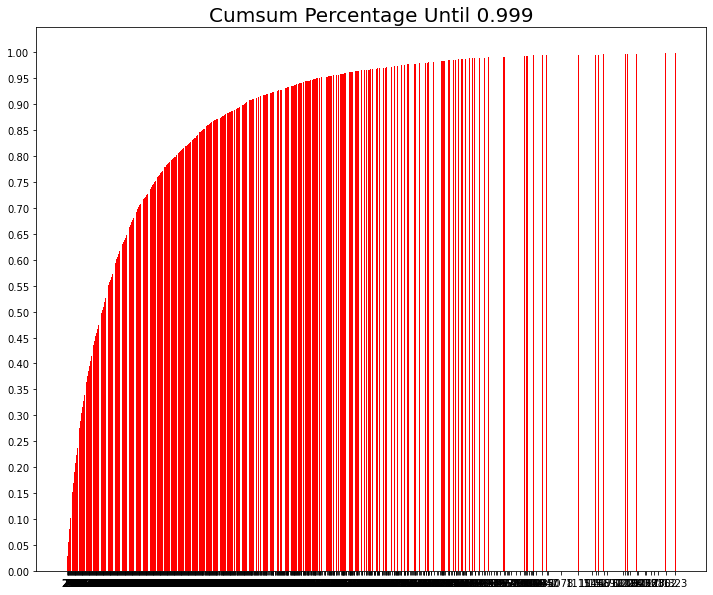

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### (3) Session Time
- 추천 시스템을 구축할 때는 최근 소비 트렌드를 학습하는 것이 중요하다. 
- 우리가 다루려는 데이터의 시간 관련 정보를 확인해보자. 

In [11]:
data['Datetime'] = '1970-01-01 00:00:00'
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%Y-%m-%d %H:%M:%S")
data.Datetime = data.Datetime + data.Time.map(lambda x : dt.timedelta(seconds=x))
data = data.drop(['Time','Rating'], axis=1)
data

,UserId,ItemId,Datetime
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [12]:
oldest, latest = data['Datetime'].min(), data['Datetime'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

### (4) Data Cleansing
- 길이가 1인 세션도 꽤 많았다. 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이기에 길이가 1인 세션은 제거한다.
- 너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있으므로 이 역시 제거한다.

In [14]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음
# 이를 위해 반복문을 통해 지속적으로 제거
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Datetime
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


### (5) Train / Valid / Test split
- 모델 평가를 위해 Valid Set과 Test Set을 만들어보자.

In [16]:
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [17]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Datetime'].max()
    user_last_time = data.groupby('UserId')['Datetime'].max().sort_values()
    user_in_train = data[data['Datetime'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Datetime'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

In [18]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [19]:
# data에 대한 정보 살펴보기
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Datetime"].min()}\n'
          f'\t Last Time : {data["Datetime"].max()}\n')

In [20]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Users: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Users: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8806
	 Users: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [21]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [22]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline
- Session-Parallel Mini-Batch 구현  

### (1) Session Dataset
- 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [23]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [24]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Datetime,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
36,1,1836,2000-12-31 22:02:52,5
3,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
47,1,1207,2000-12-31 22:11:59,8
0,1,1193,2000-12-31 22:12:40,9


In [25]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [26]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

### (2) Session Data Loader
- `SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.
- `__iter__` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다.
- mask는 후에 RNN Cell State를 초기화하는데 사용한다.

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=512)
tr_dataset.df.head(15)

,UserId,ItemId,Datetime,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
36,1,1836,2000-12-31 22:02:52,5
3,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
47,1,1207,2000-12-31 22:11:59,8
0,1,1193,2000-12-31 22:12:40,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [   0   53   65   54   56  385    1   54  514  429   53  829   37  860
  870  927  945   93  985   16  944   78  218   89 1046   65  552    9
 1468  805 1491   89  799 1592  117 1205 1083  599    2   81   32    9
  125 1600 1096 1732    9   37  163 1115  267   65   93    9  453   93
 2001 1912   11  593 1180  267  325   53  597   16  599 2135  183  237
 2058   54   78    2 2167 1784 2200  235  661  134 2159  385   78  125
 1159  408 2232   91  502  126 1400 1105  163 1068   81    9  386 1499
  507  668  491  739  554  552  134   91 1022    1    1  546 1090 2326
  491 1771  343 1671  186 1234  664   11   53   16   28   93 1633   93
    1 1046 1908  267   54 2320   62  901 2258    9  165  501    9   15
 1258  155   37  127 1391   78   49  109  326  316  517 1054 1340   78
  874  799  552  386  114   24   81    2 1173   24   53   91  483  685
  611  267   82 1505  154  688  134  258   11    9   78 1468  405  514
   25   78  163 2016   65  385 1440    2   11  191

## Modeling
### (1) Evaluation Metric

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### (2) Model Architecture

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [33]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [34]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [35]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


### (3) Model Training

In [36]:
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
train_model(model, args)

Evaluation:  45%|████▍     | 41/92 [00:23<00:29,  1.71it/s]


	 - Recall@20 epoch 1: 0.096799
	 - MRR@20    epoch 1: 0.026789



Evaluation:  45%|████▍     | 41/92 [00:23<00:28,  1.76it/s]


	 - Recall@20 epoch 2: 0.122904
	 - MRR@20    epoch 2: 0.033864



Evaluation:  45%|████▍     | 41/92 [00:23<00:28,  1.78it/s]

	 - Recall@20 epoch 3: 0.129954
	 - MRR@20    epoch 3: 0.036671



In [38]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  36%|███▋      | 24/66 [00:13<00:23,  1.77it/s]

	 - Recall@20: 0.139648
	 - MRR@20: 0.041223



In [39]:
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.3, lr=0.001, epochs=3, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_1 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_1 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 124/185 [00:36<00:17,  3.43it/s]


	 - Recall@20 epoch 1: 0.118070
	 - MRR@20    epoch 1: 0.033717



Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.48it/s]


	 - Recall@20 epoch 2: 0.135081
	 - MRR@20    epoch 2: 0.039857



Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.46it/s]

	 - Recall@20 epoch 3: 0.138357
	 - MRR@20    epoch 3: 0.041538



In [40]:
test_model(model, args, test)

Evaluation:  59%|█████▉    | 78/132 [00:22<00:15,  3.48it/s]

	 - Recall@20: 0.161659
	 - MRR@20: 0.047363



In [41]:
args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.3, lr=0.002, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1055400   
_________________________________________________________________
dropout_2 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_2 (Dense)              (64, 3416)                345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.47it/s]


	 - Recall@20 epoch 1: 0.132182
	 - MRR@20    epoch 1: 0.036288



Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.50it/s]


	 - Recall@20 epoch 2: 0.139239
	 - MRR@20    epoch 2: 0.039870



Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.54it/s]


	 - Recall@20 epoch 3: 0.139239
	 - MRR@20    epoch 3: 0.041570



Evaluation:  67%|██████▋   | 124/185 [00:35<00:17,  3.50it/s]


	 - Recall@20 epoch 4: 0.137475
	 - MRR@20    epoch 4: 0.040661



Evaluation:  67%|██████▋   | 124/185 [00:34<00:17,  3.56it/s]

	 - Recall@20 epoch 5: 0.138987
	 - MRR@20    epoch 5: 0.041165



In [42]:
test_model(model, args, test)

Evaluation:  59%|█████▉    | 78/132 [00:21<00:15,  3.58it/s]

	 - Recall@20: 0.162059
	 - MRR@20: 0.048751



In [43]:
args = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.3, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1055400   
_________________________________________________________________
dropout_3 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_3 (Dense)              (256, 3416)               345016    
Total params: 1,400,416
Trainable params: 1,400,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.10s/it]


	 - Recall@20 epoch 1: 0.074777
	 - MRR@20    epoch 1: 0.017909



Evaluation:  15%|█▌        | 7/46 [00:07<00:41,  1.06s/it]


	 - Recall@20 epoch 2: 0.107143
	 - MRR@20    epoch 2: 0.031548



Evaluation:  15%|█▌        | 7/46 [00:07<00:41,  1.06s/it]


	 - Recall@20 epoch 3: 0.112723
	 - MRR@20    epoch 3: 0.032730



Evaluation:  15%|█▌        | 7/46 [00:07<00:40,  1.04s/it]


	 - Recall@20 epoch 4: 0.113839
	 - MRR@20    epoch 4: 0.034736



Evaluation:  15%|█▌        | 7/46 [00:07<00:40,  1.05s/it]

	 - Recall@20 epoch 5: 0.114397
	 - MRR@20    epoch 5: 0.035050



In [44]:
test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:32,  1.05s/it]

	 - Recall@20: 0.117188
	 - MRR@20: 0.037053

